## This notebook compares PWM scans vs filter scans of a CNN using relu and exponential activations.

In [1]:
import os, sys, h5py
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, roc_auc_score

from six.moves import cPickle
from tensorflow import keras
import helper
from tfomics import utils, metrics

# plotting tools
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline


Using TensorFlow backend.


In [2]:
       
def interpretability_performance(X, score, X_model, buffer=20):
    """Function to calculate the localization performance for a motif scan. Buffer is added
       to deal with motif positions within convolutional filters."""
    
    pr_score = []
    roc_score = []
    for j, gs in enumerate(score):

        # calculate information of ground truth
        gt_info = np.log2(4) + np.sum(X_model[j]*np.log2(X_model[j]+1e-10),axis=0)

        # set label if information is greater than 0
        label = np.zeros(gt_info.shape)
        label[gt_info > 0.01] = 1
        
        # extend labels
        box_filter = np.ones(buffer)
        pad_left = int(buffer/2)
        pad_right = buffer - pad_left
        x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
        new_label = []
        for n in range(L):
            new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
        new_label = np.array(new_label)
        new_label[new_label > 0.01] = 1

        # get positive instance 
        pos_instance = []
        index = 0
        status = True
        while status:
            s = np.where(new_label[index:] == 1)[0]
            if any(list(s)):
                start = index + s[0]
            else:
                status = False
            e = np.where(new_label[index+start:] == 0)[0]
            if any(list(e)):
                end = index + start + e[0]
                pos_instance.append(np.max(gs[start:end]))
                index = end
            else:
                status = False
        
        # get negative instance
        neg_instance = []
        index = 0
        status = True
        while status:
            s = np.where(new_label[index:] == 0)[0]
            if any(list(s)):
                start = index + s[0]
            else:
                status = False
            e = np.where(new_label[index+start:] == 1)[0]
            if any(list(e)):
                end = index + start + e[0]
                neg_instance.append(np.max(gs[start:end]))
                index = end
            else:
                end = L
                neg_instance.append(np.max(gs[start:end]))
                status = False

        vals = np.concatenate([pos_instance, neg_instance])
        labels = np.concatenate([np.ones(len(pos_instance)), np.zeros(len(neg_instance))])

        # precision recall metric
        precision, recall, thresholds = precision_recall_curve(labels, vals)
        pr_score.append(auc(recall, precision))

        # roc curve
        fpr, tpr, thresholds = roc_curve(labels, vals)
        roc_score.append(auc(fpr, tpr))

    roc_score = np.array(roc_score)
    pr_score = np.array(pr_score)

    return roc_score, pr_score
    

In [4]:
# load data
data_path = '../data/synthetic_dataset.h5'
data = helper.load_data(data_path)
x_train, y_train, x_valid, y_valid, x_test, y_test = data

# load ground truth values
test_model = helper.load_synthetic_models(data_path, dataset='test')
X = x_test
X_model = test_model
print(X.shape)

(6000, 200, 4)


## Get ground truth motifs from JASPAR database

In [5]:
def get_jaspar_motifs(file_path):
    def get_motif(f):
        line = f.readline()
        name = line.strip().split()[1]
        pfm = []
        for i in range(4):
            line = f.readline()
            if len(line.split()[1]) > 1:
                pfm.append(np.asarray(np.hstack([line.split()[1][1:], line.split()[2:-1]]), dtype=float))
            else:
                pfm.append(np.asarray(line.split()[2:-1], dtype=float))
        pfm = np.vstack(pfm)
        sum_pfm = np.sum(pfm, axis=0)
        pwm = pfm/np.outer(np.ones(4), sum_pfm)
        line = f.readline()
        return name, pwm

    num_lines = sum(1 for line in open(file_path))
    num_motifs = int(num_lines/6)

    f = open(file_path)
    tf_names = []
    tf_motifs = []
    for i in range(num_motifs):
        name, pwm = get_motif(f)
        tf_names.append(name)
        tf_motifs.append(pwm)

    return tf_motifs, tf_names

# parse JASPAR motifs
savepath = '../data'
file_path = os.path.join(savepath, 'pfm_vertebrates.txt')
motif_set, motif_names = get_jaspar_motifs(file_path)

# get a subset of core motifs 
core_names = ['Arid3a', 'CEBPB', 'FOSL1', 'Gabpa', 'MAFK', 'MAX', 
              'MEF2A', 'NFYB', 'SP1', 'SRF', 'STAT1', 'YY1']
strand_motifs = []
core_index = []
for name in core_names:
    strand_motifs.append(motif_set[motif_names.index(name)])
    core_index.append(motif_names.index(name))

# generate reverse compliments
core_motifs = []
for pwm in strand_motifs:
    core_motifs.append(pwm)
    reverse = pwm[:,::-1]
    core_motifs.append(reverse[::-1,:]) 


#### Calculate scans with JASPAR motifs and PWM scans

In [15]:
N, L, A = X.shape
num_motifs = len(core_motifs)

fmap_all = []
fmap_pwm = []
for n, x in enumerate(X):
    if np.mod(n+1,250) == 0:
        print("%d out of %d"%(n+1, N))
    fmap_motifs = []
    fmap_motifs_pwm = []
    for i in range(num_motifs):
        
        # get the motif position probability matrix
        ppm = core_motifs[i]
        ppm = ppm.T

        # calculate the PWM
        pwm = np.log2(core_motifs[i]/(np.ones(core_motifs[i].shape)/4)+1e-10)
        pwm = pwm.T

        # zero-pad to get same shape as original sequence
        M = ppm.shape[0]
        num_pad = M
        pad_left = int(num_pad/2)
        pad_right = num_pad - pad_left
        x_pad = np.concatenate([np.zeros((pad_left, 4)), x, np.zeros((pad_right,4))], axis=0) 
        
        # calculate motif scan
        fmap = []
        for n in range(L):
            fmap.append(np.sum(x_pad[range(n,n+M),:] * ppm))            
        fmap_motifs.append(fmap)
        

        # calculate PWM scan
        fmap = []
        for n in range(L):
            fmap.append(np.sum(x_pad[range(n,n+M),:] * pwm))            
        fmap_motifs_pwm.append(fmap)
        
        
    fmap_all.append(fmap_motifs)
    fmap_pwm.append(fmap_motifs_pwm)
fmap_all = np.array(fmap_all)
fmap_pwm = np.array(fmap_pwm)
    

KeyboardInterrupt: 

#### Print localization performance for motif scan and pwm scan

In [8]:
score = np.max(fmap_all, axis=1)
ppm_roc_score, ppm_pr_score = interpretability_performance(X, score, X_model, buffer=10)
print('Motif scan results')
print("AUROC: %.4f+/-%.4f"%(np.nanmean(ppm_roc_score), np.nanstd(ppm_roc_score)))
print("AUPR: %.4f+/-%.4f"%(np.nanmean(ppm_pr_score), np.nanstd(ppm_pr_score)))

score = np.max(fmap_pwm, axis=1)
pwm_roc_score, pwm_pr_score = interpretability_performance(X, score, X_model, buffer=10)
print('PWM results')
print("AUROC: %.4f+/-%.4f"%(np.nanmean(pwm_roc_score), np.nanstd(pwm_roc_score)))
print("AUPR: %.4f+/-%.4f"%(np.nanmean(pwm_pr_score), np.nanstd(pwm_pr_score)))

/home/peter/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/peter/.local/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Motif scan results
AUROC: 0.6667+/-0.3372
AUPR: 0.6476+/-0.3315
PWM results
AUROC: 0.6667+/-0.3372
AUPR: 0.6476+/-0.3315


In [10]:
# save results for scans
results_path = os.path.join('../results', 'task1')
with open(os.path.join(results_path, 'pwm_scans.pickle'), 'wb') as f:
    cPickle.dump(pwm_roc_score, f)
    cPickle.dump(pwm_pr_score, f)    
    cPickle.dump(ppm_roc_score, f)
    cPickle.dump(ppm_pr_score, f)    

# Get filter scans for first convolutional layer filters

In [11]:

num_trials = 10
model_names = ['cnn-deep']
activations = ['exponential', 'relu']

results_path = os.path.join('../results', 'task1')
params_path = os.path.join(results_path, 'model_params')

results = {}
for model_name in model_names:
    for activation in activations:
        results[model_name+'_'+activation] = []
        for trial in range(num_trials):
            keras.backend.clear_session()
            
            # load model
            model = helper.load_model(model_name, 
                                            activation=activation, 
                                            input_shape=200)
            name = model_name+'_'+activation+'_'+str(trial)
            print('model: ' + name)

            weights_path = os.path.join(params_path, name+'.hdf5')
            model.load_weights(weights_path)            
            
            intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[3].output)
            results[model_name+'_'+activation].append(intermediate.predict(X))
        

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
model: cnn-deep_exponential_0
model: cnn-deep_exponential_1
model: cnn-deep_exponential_2
model: cnn-deep_exponential_3
model: cnn-deep_exponential_4
model: cnn-deep_exponential_5
model: cnn-deep_exponential_6
model: cnn-deep_exponential_7
model: cnn-deep_exponential_8
model: cnn-deep_exponential_9
model: cnn-deep_relu_0
model: cnn-deep_relu_1
model: cnn-deep_relu_2
model: cnn-deep_relu_3
model: cnn-deep_relu_4
model: cnn-deep_relu_5
model: cnn-deep_relu_6
model: cnn-deep_relu_7
model: cnn-deep_relu_8
model: cnn-deep_relu_9


In [12]:
# save filter scans
with open(os.path.join(results_path, 'fmaps.pickle'), 'wb') as f:
    cPickle.dump(results, f, protocol=cPickle.HIGHEST_PROTOCOL)

# Plot scan comparison

In [13]:
plot_path = utils.make_directory(results_path, 'pwm_comparison')

model_name = 'cnn-deep'
fmap_deep_relu = results[model_name+'_relu'][0]
fmap_deep_exp = results[model_name+'_exponential'][0]

([], <a list of 0 Text yticklabel objects>)

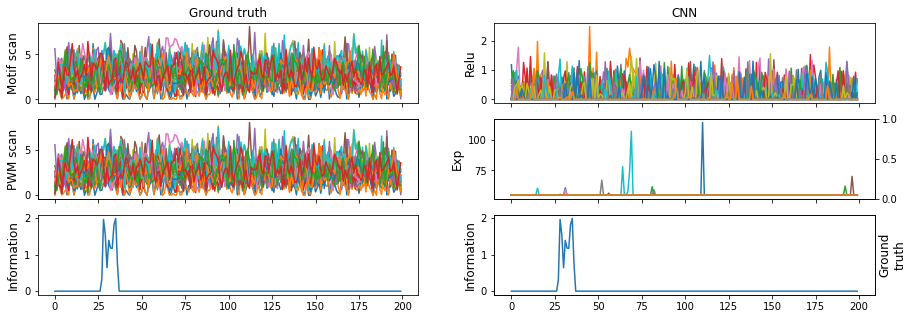

In [14]:
index = 0
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(3,2,1)
ax.plot(np.maximum(fmap_all[index].T, 0));
ax.set_xticklabels([])
plt.title('Ground truth', fontsize=12)
plt.ylabel('Motif scan', fontsize=12)
#plt.figure()
#plt.plot(fmap_deep_relu[index]);

ax = plt.subplot(3,2,2)

threshold = np.exp(-10)
ax.plot(np.maximum(fmap_deep_relu[index], threshold));
ax.set_xticklabels([])
plt.title('CNN', fontsize=12)
plt.ylabel('Relu', fontsize=12)


ax = plt.subplot(3,2,3)
ax.plot(np.maximum(fmap_pwm[index].T, 0));
plt.ylabel('PWM scan', fontsize=12)
ax.set_xticklabels([])
ax2 = ax.twinx()
#plt.ylabel('PWM', fontsize=12)
plt.yticks([])

ax = plt.subplot(3,2,4)
threshold = np.exp(4)
ax.plot(np.maximum(fmap_deep_exp[index], threshold));
ax.set_xticklabels([])
plt.ylabel('Exp', fontsize=12)
ax2 = ax.twinx()


ax = plt.subplot(3,2,5)
buffer = 1

# calculate information of ground truth
gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

# set label if information is greater than 0
label = np.zeros(gt_info.shape)
label[gt_info > 0.01] = 1

# extend labels
box_filter = np.ones(buffer)
pad_left = int(buffer/2)
pad_right = buffer - pad_left
x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
new_label = []
for n in range(L):
    new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
new_label = np.array(new_label)
new_label[new_label > 0.01] = 1
plt.ylabel('Information', fontsize=12)

ax.plot(gt_info);

ax = plt.subplot(3,2,6)
buffer = 1

# calculate information of ground truth
gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

# set label if information is greater than 0
label = np.zeros(gt_info.shape)
label[gt_info > 0.01] = 1

# extend labels
box_filter = np.ones(buffer)
pad_left = int(buffer/2)
pad_right = buffer - pad_left
x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
new_label = []
for n in range(L):
    new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
new_label = np.array(new_label)
new_label[new_label > 0.01] = 1
plt.ylabel('Information', fontsize=12)

ax.plot(gt_info);
ax2 = ax.twinx()
plt.ylabel('Ground\ntruth', fontsize=12)
plt.yticks([])


# Plot scan comparisons for many examples

In [ ]:

num_plots = 20
for index in indices[:num_plots]:
    fig = plt.figure(figsize=(15,5))

    ax = plt.subplot(3,2,1)
    ax.plot(np.maximum(fmap_all[index].T, 0));
    ax.set_xticklabels([])
    plt.title('Ground truth', fontsize=12)
    plt.ylabel('Motif scan', fontsize=12)
    #plt.figure()
    #plt.plot(fmap_deep_relu[index]);

    ax = plt.subplot(3,2,2)

    threshold = np.exp(-10)
    ax.plot(np.maximum(fmap_deep_relu[index], threshold));
    ax.set_xticklabels([])
    plt.title('CNN', fontsize=12)
    plt.ylabel('Relu', fontsize=12)


    ax = plt.subplot(3,2,3)
    ax.plot(np.maximum(fmap_pwm[index].T, 0));
    plt.ylabel('PWM scan', fontsize=12)
    ax.set_xticklabels([])
    ax2 = ax.twinx()
    #plt.ylabel('PWM', fontsize=12)
    plt.yticks([])

    ax = plt.subplot(3,2,4)
    threshold = np.exp(4)
    ax.plot(np.maximum(fmap_deep_exp[index], threshold));
    ax.set_xticklabels([])
    plt.ylabel('Exp', fontsize=12)
    ax2 = ax.twinx()


    ax = plt.subplot(3,2,5)
    buffer = 1

    # calculate information of ground truth
    gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

    # set label if information is greater than 0
    label = np.zeros(gt_info.shape)
    label[gt_info > 0.01] = 1

    # extend labels
    box_filter = np.ones(buffer)
    pad_left = int(buffer/2)
    pad_right = buffer - pad_left
    x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
    new_label = []
    for n in range(L):
        new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
    new_label = np.array(new_label)
    new_label[new_label > 0.01] = 1
    plt.ylabel('Information', fontsize=12)

    ax.plot(gt_info);

    ax = plt.subplot(3,2,6)
    buffer = 1

    # calculate information of ground truth
    gt_info = np.log2(4) + np.sum(X_model[index]*np.log2(X_model[index]+1e-10),axis=0)

    # set label if information is greater than 0
    label = np.zeros(gt_info.shape)
    label[gt_info > 0.01] = 1

    # extend labels
    box_filter = np.ones(buffer)
    pad_left = int(buffer/2)
    pad_right = buffer - pad_left
    x_pad = np.concatenate([np.zeros(pad_left), label, np.zeros(pad_right)], axis=0) 
    new_label = []
    for n in range(L):
        new_label.append(np.sum(x_pad[range(n,n+buffer)] * box_filter))            
    new_label = np.array(new_label)
    new_label[new_label > 0.01] = 1
    plt.ylabel('Information', fontsize=12)

    ax.plot(gt_info);
    ax2 = ax.twinx()
    plt.ylabel('Ground\ntruth', fontsize=12)
    plt.yticks([])

    outfile = os.path.join(plot_path, 'pwm_comparison_'+str(index))
    fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')
    plt.close()
